# Baremetal Experiment Pattern

This is a simple experiment that illustrates how you can capture power measurements from the bare metal machine directly. It's also an example of how to structure an experiment in a reproducible manner, and illustrates several of the capabilities offered by Chameleon for reproducibility. 

## Configuring resources

We need to configure the experiment "container," meaning to isolated, reproducible environment that our experiment will run in. Initially, this will configure Chameleon resources to the point where you will be able `ssh` to a node. The remainder of this setup is installing software on that node, which in this case is loaded from GitHub.

The first thing you must do is set what site and project to use. You can select this from the dropdown that displays, or use the defaults that are automatically picked. For more information about setting context in python-chi, [see here](https://python-chi.readthedocs.io/en/dev/modules/context.html).

In [1]:
from chi import context

# During the transition period, we need to opt into the some of the 
# new python-chi functions. Otherwise the functional interface will
# return the old types.
context.version = "1.0"

context.choose_site(default="CHI@TACC")
context.choose_project()

### Check available hardware

Next, we'll pick which hardware to us. The following code cell looks for nodes of type matching the `node_type` variable, and filters our ones that are reserved.

This information comes from [the Chameleon hardware repository](https://chameleoncloud.org/hardware), and can be [queryed via python-chi](https://python-chi.readthedocs.io/en/dev/modules/hardware.html).

In [3]:
from chi import hardware

node_type = "compute_icelake_r650"
available_nodes = hardware.get_nodes(node_type=node_type, filter_reserved=True)
if available_nodes:
    print(f"There currently are {len(available_nodes)} {node_type} nodes ready to use")
    hardware.show_nodes(available_nodes)
else:
    print(f"All {node_type} nodes are in use! You could use next_free_timeslot to see how long you need to wait, or use the calendar.")

There currently are 4 compute_icelake_r650 nodes ready to use


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'Node Name': 80, 'Sit…

### Reserve node

In order to use hardware on Chameleon, you'll need to [make a reservation](https://chameleoncloud.readthedocs.io/en/latest/technical/reservations.html). You can do this via [the python-chi lease module](https://python-chi.readthedocs.io/en/dev/modules/lease.html).

If the resources you want to use are currently free, you can make a lease that starts right now. The following code does this to reserve one of the nodes found above, and it also reserves a floating ip.

In [26]:
from chi import lease
from datetime import timedelta
import os

my_lease = lease.Lease(f"{os.getenv('USER')}-power-management", duration=timedelta(hours=3))
my_lease.add_node_reservation(nodes=[available_nodes[0]]) # or you could use node_type=node_type
# my_lease.add_fip_reservation(1) # include a floating ip
my_lease.submit(idempotent=True)

Waiting for lease to start...


Lease jimlauda_ucsc_edu-power-management has reached status active


In [27]:
from chi import network
fp = network.get_free_floating_ip()
print(f"Got floating IP {fp}")

The python binding code in neutronclient is deprecated in favor of OpenstackSDK, please use that as this will be removed in a future release.


Got floating IP {'id': 'a6416dff-b36a-4b3a-8fe0-961e22fce203', 'tenant_id': 'c0db950add004ead938f2fd3fb36e439', 'floating_ip_address': '129.114.108.33', 'floating_network_id': '6189521e-06a0-4c43-b163-16cc11ce675b', 'router_id': None, 'port_id': None, 'fixed_ip_address': None, 'status': 'DOWN', 'description': '', 'port_details': None, 'tags': [], 'created_at': '2025-08-14T00:56:09Z', 'updated_at': '2025-08-14T03:51:14Z', 'revision_number': 5, 'project_id': 'c0db950add004ead938f2fd3fb36e439'}


### Create a server on the node

Next, we will launch the reserved node with [an image](https://chameleoncloud.readthedocs.io/en/latest/technical/images.html). You can search for [Chameleon supported images in python-chi](https://python-chi.readthedocs.io/en/dev/modules/image.html). Here, we use an Ubuntu image.

Then, we submit the request to create a server, using the reservation information from our lease. You'll need to wait for the server to fully provision, which can around 10 minutes depending on the node.

In [28]:
from chi import server

my_server = server.Server(
    f"{os.getenv('USER')}-power-management",
    reservation_id=my_lease.node_reservations[0]["id"],
    image_name="CC-Ubuntu22.04", # or use image_name
)
my_server.submit(idempotent=True)

The python binding code in neutronclient is deprecated in favor of OpenstackSDK, please use that as this will be removed in a future release.


Waiting for server jimlauda_ucsc_edu-power-management's status to become ACTIVE. This typically takes 10 minutes for baremetal, but can take up to 20 minutes.


Server has moved to status ACTIVE


Attribute,jimlauda_ucsc_edu-power-management
Id,e9ed7146-5189-4a90-8906-bf7a15dc71b0
Status,ACTIVE
Image Name,CC-Ubuntu22.04
Flavor Name,baremetal
Addresses,sharednet1: IP: 10.52.3.128 (v4) Type: fixed MAC: 14:23:f2:c9:7d:c0
Network Name,sharednet1
Created At,2025-08-14T03:56:46Z
Keypair,trovi-ed5c1cf
Reservation Id,4eba50a8-de28-4d76-b16c-a4e66ae268df
Host Id,cb48ed2ea6d1983af1639be2c5b495a227f80c2843b660ca3d2c6f42


### Configure networking on the node

Now, we must configure the server to use the floating IP we reserved earlier. We'll also need to wait for the networking to finish configuring, which may take a few additional minutes.

In [29]:
fip = network.get_floating_ip(fp['floating_ip_address'])
fip

The python binding code in neutronclient is deprecated in favor of OpenstackSDK, please use that as this will be removed in a future release.


{'id': 'a6416dff-b36a-4b3a-8fe0-961e22fce203',
 'tenant_id': 'c0db950add004ead938f2fd3fb36e439',
 'floating_ip_address': '129.114.108.33',
 'floating_network_id': '6189521e-06a0-4c43-b163-16cc11ce675b',
 'router_id': None,
 'port_id': None,
 'fixed_ip_address': None,
 'status': 'DOWN',
 'description': '',
 'port_details': None,
 'tags': [],
 'created_at': '2025-08-14T00:56:09Z',
 'updated_at': '2025-08-14T03:51:14Z',
 'revision_number': 5,
 'project_id': 'c0db950add004ead938f2fd3fb36e439'}

In [30]:
network.list_floating_ips()[0]

The python binding code in neutronclient is deprecated in favor of OpenstackSDK, please use that as this will be removed in a future release.


{'id': 'a6416dff-b36a-4b3a-8fe0-961e22fce203',
 'tenant_id': 'c0db950add004ead938f2fd3fb36e439',
 'floating_ip_address': '129.114.108.33',
 'floating_network_id': '6189521e-06a0-4c43-b163-16cc11ce675b',
 'router_id': None,
 'port_id': None,
 'fixed_ip_address': None,
 'status': 'DOWN',
 'description': '',
 'port_details': None,
 'tags': [],
 'created_at': '2025-08-14T00:56:09Z',
 'updated_at': '2025-08-14T03:51:14Z',
 'revision_number': 5,
 'project_id': 'c0db950add004ead938f2fd3fb36e439'}

In [33]:
fip = network.list_floating_ips()[0]
my_server.associate_floating_ip(fip['floating_ip_address'])
# my_server.check_connectivity(host=fip)

The python binding code in neutronclient is deprecated in favor of OpenstackSDK, please use that as this will be removed in a future release.
The python binding code in neutronclient is deprecated in favor of OpenstackSDK, please use that as this will be removed in a future release.


'129.114.108.33'

### Install software on the node

Now we will install our software on the node, over SSH. In your own experiment, you would likely want to change these commands.

You can use the `execute` [method](https://python-chi.readthedocs.io/en/dev/modules/server.html#chi.server.Server.execute) or for more advance usage you can [get a Fabric Connection object](https://python-chi.readthedocs.io/en/dev/modules/server.html#chi.server.Server.ssh_connection).

In [39]:
# Clone git repo with experiment source code
my_server.execute("git clone --recursive https://github.com/jessdagostini/miniGiraffe.git")

# Run setup script
my_server.execute("cd miniGiraffe && git checkout arch")

Cloning into 'miniGiraffe'...
Submodule 'deps/gbwt' (https://github.com/jltsiren/gbwt.git) registered for path 'deps/gbwt'
Submodule 'deps/gbwtgraph' (https://github.com/jltsiren/gbwtgraph.git) registered for path 'deps/gbwtgraph'
Submodule 'deps/libhandlegraph' (https://github.com/vgteam/libhandlegraph.git) registered for path 'deps/libhandlegraph'
Submodule 'deps/sdsl-lite' (https://github.com/vgteam/sdsl-lite.git) registered for path 'deps/sdsl-lite'
Cloning into '/home/cc/miniGiraffe/deps/gbwt'...
Cloning into '/home/cc/miniGiraffe/deps/gbwtgraph'...
Cloning into '/home/cc/miniGiraffe/deps/libhandlegraph'...
Cloning into '/home/cc/miniGiraffe/deps/sdsl-lite'...


Submodule path 'deps/gbwt': checked out '6ae4d24aaa1536b3cdc266cc233ddc3812f1f1a0'
Submodule path 'deps/gbwtgraph': checked out 'b5bc82b168cb20c28b7363e3e10a17b06536849f'
Submodule path 'deps/libhandlegraph': checked out 'ccc11459019680ae53b65bcc19077d41ecff3075'
Submodule path 'deps/sdsl-lite': checked out '2b3a86231fb2f38e117736aee55df391f79f2470'


Submodule 'external/googletest' (https://github.com/google/googletest.git) registered for path 'deps/sdsl-lite/external/googletest'
Submodule 'external/libdivsufsort' (https://github.com/simongog/libdivsufsort.git) registered for path 'deps/sdsl-lite/external/libdivsufsort'
Cloning into '/home/cc/miniGiraffe/deps/sdsl-lite/external/googletest'...
Cloning into '/home/cc/miniGiraffe/deps/sdsl-lite/external/libdivsufsort'...


Submodule path 'deps/sdsl-lite/external/googletest': checked out 'c2d90bddc6a2a562ee7750c14351e9ca16a6a37a'
Submodule path 'deps/sdsl-lite/external/libdivsufsort': checked out '0f24acd8de208464769c782119dacf158647f7ed'
Branch 'arch' set up to track remote branch 'arch' from 'origin'.


Switched to a new branch 'arch'


<Result cmd='cd miniGiraffe && git checkout arch' exited=0>

In [47]:
my_server.execute("sudo apt-get update && sudo apt-get -y upgrade && sudo apt-get install -y python3-pip cmake && pip3 install pandas")

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
Calculating upgrade...
The following packages have been kept back:
  linux-generic linux-headers-generic linux-image-generic
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cmake-data dh-elpa-helper emacsen-common libjsoncpp25 librhash0
  python3-wheel
Suggested packages:
  cmake-doc ninja-build cmake-format
The following NEW packages will be installed:
  cmake cmake-data dh-elpa-helper emacsen-common libjsoncpp25 librhash0
  python3-pip python3-wheel
0

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 8488 kB in 1s (13.0 MB/s)
Selecting previously unselected package libjsoncpp25:amd64.
(Reading database ... 84498 files and directories currently installed.)
Preparing to unpack .../0-libjsoncpp25_1.9.5-3_amd64.deb ...
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../1-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Selecting previously unselected package dh-elpa-helper.
Preparing to unpack .../2-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Unpacking dh-elpa-helper (2.0.9ubuntu1) ...
Selecting previously unselected package emacsen-common.
Preparing to unpack .../3-emacsen-common_3.0.4_all.deb ...
Unpacking emacsen-common (3.0.4) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../4-cmake-data_3.22.1-1ubuntu1.22.04.2_all.deb ...
Unpacking cmake-data (3.22.1-1ubuntu1.22.04.2) ...
Selecting previously unselected package cmake.
Preparing to unpack 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


<Result cmd='sudo apt-get update && sudo apt-get -y upgrade && sudo apt-get install -y python3-pip cmake && pip3 install pandas' exited=0>

In [42]:
my_server.execute("bash miniGiraffe/iiswc25/setup-environment.sh")

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2558 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2803 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [13.6 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4018 kB]
Get:9 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4163 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [624 B]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [993 kB]
Get:12 http://security.ubuntu.com/ubuntu 

miniGiraffe/iiswc25/setup-environment.sh: line 5: pip3: command not found


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cmake-data dh-elpa-helper emacsen-common libjsoncpp25 librhash0
Suggested packages:
  cmake-doc ninja-build cmake-format
The following NEW packages will be installed:
  cmake cmake-data dh-elpa-helper emacsen-common libjsoncpp25 librhash0
0 upgraded, 6 newly installed, 0 to remove and 13 not upgraded.
Need to get 7150 kB of archives.
After this operation, 31.9 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.


fatal: destination path 'miniGiraffe' already exists and is not an empty directory.
Already on 'arch'


Your branch is up to date with 'origin/arch'.
patching file deps/gbwt/include/gbwt/cached_gbwt.h
patching file deps/gbwt/src/cached_gbwt.cpp
patching file deps/gbwtgraph/include/gbwtgraph/cached_gbwtgraph.h
patching file deps/gbwtgraph/include/gbwtgraph/gbwtgraph.h
patching file deps/gbwtgraph/src/cached_gbwtgraph.cpp
Library will be installed in '/home/cc/miniGiraffe/deps/sdsl-lite'
         The pre-commit hook is not installed.
ERROR: CMake build failed.


install.sh: line 56: cmake: command not found
install-deps.sh: line 9: cmake: command not found
make: *** No targets specified and no makefile found.  Stop.
make: *** No rule to make target 'install'.  Stop.
Makefile:2: ../sdsl-lite/Make.helper: No such file or directory
make: *** No rule to make target '../sdsl-lite/Make.helper'.  Stop.


Installing GBWT to '/home/cc/miniGiraffe/deps/gbwt'.
Running 160 parallel make jobs.
Error: Cleanup failed.
Installing GBWTGraph to '/home/cc/miniGiraffe/deps/gbwtgraph'.


Makefile:2: ../sdsl-lite/Make.helper: No such file or directory
make: *** No rule to make target '../sdsl-lite/Make.helper'.  Stop.


Running 160 parallel make jobs.
Error: Cleanup failed.
g++ -fopenmp -O3 -g  -I/home/cc/miniGiraffe -I/home/cc/miniGiraffe/deps/gbwtgraph/include -I/home/cc/miniGiraffe/deps/gbwt/include -I/home/cc/miniGiraffe/deps/sdsl-lite/include -I/home/cc/miniGiraffe/deps/libhandlegraph/build/usr/local/include -I/home/cc/miniGiraffe/src -shared -fPIC -L/home/cc/miniGiraffe/deps/sdsl-lite/lib -L/home/cc/miniGiraffe/deps/gbwt/lib -L/home/cc/miniGiraffe/deps/libhandlegraph/build/usr/local/lib -L/home/cc/miniGiraffe/deps/gbwtgraph/lib src/time-utils.cpp -lgbwtgraph -lgbwt -lhandlegraph -lsdsl -ldivsufsort -ldivsufsort64  -o time-utils.so


/usr/bin/ld: cannot find -lgbwtgraph: No such file or directory
/usr/bin/ld: cannot find -lgbwt: No such file or directory
/usr/bin/ld: cannot find -lhandlegraph: No such file or directory
/usr/bin/ld: cannot find -lsdsl: No such file or directory
/usr/bin/ld: cannot find -ldivsufsort: No such file or directory
/usr/bin/ld: cannot find -ldivsufsort64: No such file or directory
collect2: error: ld returned 1 exit status
make: *** [Makefile:28: time-utils.so] Error 1
miniGiraffe/iiswc25/setup-environment.sh: line 13: ./miniGiraffe: No such file or directory


<Result cmd='bash miniGiraffe/iiswc25/setup-environment.sh' exited=0>

In [48]:
my_server.execute("cd miniGiraffe && bash install-deps.sh && make miniGiraffe && source set-env.sh && ./miniGiraffe")

patching file deps/gbwt/include/gbwt/cached_gbwt.h
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file deps/gbwt/include/gbwt/cached_gbwt.h.rej
patching file deps/gbwt/src/cached_gbwt.cpp
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file deps/gbwt/src/cached_gbwt.cpp.rej
patching file deps/gbwtgraph/include/gbwtgraph/cached_gbwtgraph.h
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file deps/gbwtgraph/include/gbwtgraph/cached_gbwtgraph.h.rej
patching file deps/gbwtgraph/include/gbwtgraph/gbwtgraph.h
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file deps/gbwtgraph/include/gbwtgraph/gbwtgraph.h.

git found: /usr/bin/git


-- Found Git: /usr/bin/git (found version "2.34.1") 


CMake Deprecation Warning at external/libdivsufsort/CMakeLists.txt:2 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


CMake Warning (dev) at external/libdivsufsort/CMakeLists.txt:7 (project):
  Policy CMP0048 is not set: project() command manages VERSION variables.
  Run "cmake --help-policy CMP0048" for policy details.  Use the cmake_policy
  command to set the policy and suppress this warning.

  The following variable(s) would be set to empty:

    PROJECT_VERSION
    PROJECT_VERSION_MAJOR
    PROJECT_VERSION_MINOR
    PROJECT_VERSION_PATCH
This warning is for project developers.  Use -Wno-dev to suppress it.



-- Performing Test HAVE_GCC_WALL
-- Performing Test HAVE_GCC_WALL - Success
-- Performing Test HAVE_GCC_FOMIT_FRAME_POINTER
-- Performing Test HAVE_GCC_FOMIT_FRAME_POINTER - Success
-- Looking for inttypes.h
-- Looking for inttypes.h - found
-- Looking for memory.h
-- Looking for memory.h - found
-- Looking for stddef.h
-- Looking for stddef.h - found
-- Looking for stdint.h
-- Looking for stdint.h - found
-- Looking for stdlib.h
-- Looking for stdlib.h - found
-- Looking for string.h
-- Looking for string.h - found
-- Looking for strings.h
-- Looking for strings.h - found
-- Looking for sys/types.h
-- Looking for sys/types.h - found
-- Performing Test HAVE_INLINE
-- Performing Test HAVE_INLINE - Success
-- Performing Test HAVE___INLINE
-- Performing Test HAVE___INLINE - Success
-- Performing Test HAVE___INLINE__
-- Performing Test HAVE___INLINE__ - Success
-- Performing Test HAVE___DECLSPEC_DLLEXPORT_
-- Performing Test HAVE___DECLSPEC_DLLEXPORT_ - Failed
-- Performing Test HAVE___DEC

CMake Deprecation Warning at external/googletest/googletest/CMakeLists.txt:48 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.




-- Found PythonInterp: /usr/bin/python3.10 (found version "3.10.12") 
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Looking for C++ include cstdio
-- Looking for C++ include cstdio - found
-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /home/cc/miniGiraffe/deps/sdsl-lite/build
/usr/bin/cmake -S/home/cc/miniGiraffe/deps/sdsl-lite -B/home/cc/miniGiraffe/deps/sdsl-lite/build --check-build-system CMakeFiles/Makefile.cmake 0
make  -f CMakeFiles/Makefile2 sdsl
make[1]: Entering directory '/home/cc/miniGiraffe/deps/sdsl-lite/build'
/usr/bin/cmake -S/home/cc/miniGiraffe/deps/sdsl-lite -B/home/cc/miniGiraffe/deps/sdsl-lite/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /home/cc/miniGiraffe/deps/sdsl-lite/build/CMakeFiles 8
make  -

In file included from /home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../include/sdsl/int_vector.hpp:24,
                 from /home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../include/sdsl/bp_support_algorithm.hpp:24,
                 from /home/cc/miniGiraffe/deps/sdsl-lite/lib/bp_support_algorithm.cpp:1:
In static member function ‘static void sdsl::bits::write_int(uint64_t*, uint64_t, uint8_t, uint8_t)’,
    inlined from ‘static void sdsl::memory_manager::resize(t_vec&, typename t_vec::size_type) [with t_vec = sdsl::int_vector<0>]’ at /home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../include/sdsl/memory_management.hpp:364:36,
    inlined from ‘void sdsl::int_vector<<anonymous> >::bit_resize(sdsl::int_vector<<anonymous> >::size_type) [with unsigned char t_width = 0]’ at /home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../include/sdsl/int_vector.hpp:1358:27,
    inlined from ‘void sdsl::int_vector<<anonymous> >::resize(sdsl::int_vector<<anonymous> >::size_type) [with unsigned char t_width = 

[ 12%] Building CXX object lib/CMakeFiles/sdsl.dir/coder_elias_delta.cpp.o
cd /home/cc/miniGiraffe/deps/sdsl-lite/build/lib && /usr/bin/c++ -DMODE_TI -I/home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../include -I/home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../external/libdivsufsort/include -I/home/cc/miniGiraffe/deps/sdsl-lite/include -std=c++14 -Wall -Wextra -DNDEBUG -O3 -DNDEBUG -MD -MT lib/CMakeFiles/sdsl.dir/coder_elias_delta.cpp.o -MF CMakeFiles/sdsl.dir/coder_elias_delta.cpp.o.d -o CMakeFiles/sdsl.dir/coder_elias_delta.cpp.o -c /home/cc/miniGiraffe/deps/sdsl-lite/lib/coder_elias_delta.cpp
[ 12%] Building CXX object lib/CMakeFiles/sdsl.dir/coder_elias_gamma.cpp.o
cd /home/cc/miniGiraffe/deps/sdsl-lite/build/lib && /usr/bin/c++ -DMODE_TI -I/home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../include -I/home/cc/miniGiraffe/deps/sdsl-lite/build/lib/../external/libdivsufsort/include -I/home/cc/miniGiraffe/deps/sdsl-lite/include -std=c++14 -Wall -Wextra -DNDEBUG -O3 -DNDEBUG -MD -MT lib/CM

mkdir: cannot create directory ‘build’: File exists
CMake Warning (dev) at /usr/share/cmake-3.22/Modules/GNUInstallDirs.cmake:239 (message):
  Unable to determine default CMAKE_INSTALL_LIBDIR directory because no
  target architecture is known.  Please enable at least one language before
  including GNUInstallDirs.
Call Stack (most recent call first):
  CMakeLists.txt:5 (include)
This warning is for project developers.  Use -Wno-dev to suppress it.



lude/sdsl/rmq_succinct_sct.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/rmq_support.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/rmq_support_sparse_table.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/rrr_helper.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/rrr_vector.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/rrr_vector_15.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/sd_vector.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/sdsl_concepts.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/select_support.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/select_support_mcl.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/select_support_scan.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sdsl/sfstream.hpp
-- Installing: /home/cc/miniGiraffe/deps/sdsl-lite/include/sd

libhandlegraph is root project or external_project


-- Configuring done
-- Generating done
-- Build files have been written to: /home/cc/miniGiraffe/deps/libhandlegraph/build
[  2%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/deletable_handle_graph.cpp.o
[  5%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/dfs.cpp.o
[  8%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/handle_graph.cpp.o
[ 11%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/mutable_handle_graph.cpp.o
[ 14%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/path_metadata.cpp.o
[ 17%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/mutable_path_metadata.cpp.o
[ 20%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/path_handle_graph.cpp.o
[ 22%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/path_position_handle_graph.cpp.o
[ 25%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/mutable_path_handle_graph.cpp.o
[ 28%] Building CXX object CMakeFiles/handlegraph_objs.dir/src/ranked_handle_graph.cpp.o

UnexpectedExit: Encountered a bad command exit code!

Command: 'cd miniGiraffe && bash install-deps.sh && make miniGiraffe && source set-env.sh && ./miniGiraffe'

Exit code: 1

Stdout: already printed

Stderr: already printed



In [49]:
my_server.execute("cd miniGiraffe && make miniGiraffe && source set-env.sh && ./miniGiraffe")

g++ -fopenmp -O3 -g  -I/home/cc/miniGiraffe -I/home/cc/miniGiraffe/deps/gbwtgraph/include -I/home/cc/miniGiraffe/deps/gbwt/include -I/home/cc/miniGiraffe/deps/sdsl-lite/include -I/home/cc/miniGiraffe/deps/libhandlegraph/build/usr/local/include -I/home/cc/miniGiraffe/src -shared -fPIC -L/home/cc/miniGiraffe/deps/sdsl-lite/lib -L/home/cc/miniGiraffe/deps/gbwt/lib -L/home/cc/miniGiraffe/deps/libhandlegraph/build/usr/local/lib -L/home/cc/miniGiraffe/deps/gbwtgraph/lib src/time-utils.cpp -lgbwtgraph -lgbwt -lhandlegraph -lsdsl -ldivsufsort -ldivsufsort64  -o time-utils.so
g++ -fopenmp -O3 -g  -I/home/cc/miniGiraffe -I/home/cc/miniGiraffe/deps/gbwtgraph/include -I/home/cc/miniGiraffe/deps/gbwt/include -I/home/cc/miniGiraffe/deps/sdsl-lite/include -I/home/cc/miniGiraffe/deps/libhandlegraph/build/usr/local/include -I/home/cc/miniGiraffe/src -shared -fPIC -L/home/cc/miniGiraffe/deps/sdsl-lite/lib -L/home/cc/miniGiraffe/deps/gbwt/lib -L/home/cc/miniGiraffe/deps/libhandlegraph/build/usr/local/lib

Usage miniGiraffe [seed_file] [gbz_file] [options]
Options: 
   -t, number of threads (default: max # threads in system)
   -c, initial GBWTcache capacity (default: 256)
   -b, batch size (default: 512)
   -s, scheduler [omp, ws] (default: omp)
   -p, enable profiling (default: disabled)
   -o, write extension output (default: disabled)
   -m <list>, comma-separated list of hardware measurements to enable (default: disabled)
              Available counters: IPC, L1CACHE, LLCACHE, BRANCHES, DTLB, ITLB
              Not recommended to enable more than 3 hw measurement per run
              given hardware counters constraints


<Result cmd='cd miniGiraffe && make miniGiraffe && source set-env.sh && ./miniGiraffe' exited=0>

In [50]:
my_server.execute("cd miniGiraffe && g++ src/lower-input.cpp -o lower-input && chmod +x lower-input")

<Result cmd='cd miniGiraffe && g++ src/lower-input.cpp -o lower-input && chmod +x lower-input' exited=0>

## Run Experiment

Now, we can finally run the experiment. This will run the `stress-ng` program on different numbers of CPUs for 10 seconds, and measures the power consumption via `perf`. For more information on measuring power, see [this Chameleon blog post](https://chameleoncloud.org/blog/2024/06/18/power-measurement-and-management-on-chameleon/).

You can edit `iterations` to gather more data points, which will result in a more interesting result.

In [54]:
my_server.execute("python3 miniGiraffe/iiswc25/tuning-pipeline.py")

2025-08-14 04:42:09,991 MiniGiraffePipeline - INFO - ***Starting miniGiraffe pipeline***
2025-08-14 04:42:09,991 MiniGiraffePipeline - INFO - [Main] Source folder: /home/cc/miniGiraffe
2025-08-14 04:42:09,991 MiniGiraffePipeline - INFO - [Main] Destination folder: /home/cc/miniGiraffe/iiswc25
2025-08-14 04:42:09,991 MiniGiraffePipeline - WARNING - [Main] Destination folder already exists: /home/cc/miniGiraffe/iiswc25
2025-08-14 04:42:10,644 MiniGiraffePipeline - WARNING - [Download Zenodo] File already exists: /home/cc/miniGiraffe/iiswc25/1000GPlons_hs38d1_filter.giraffe.gbz
2025-08-14 04:42:10,644 MiniGiraffePipeline - INFO - [Download Zenodo] Downloading: dump_proxy_novaseq.bin
2025-08-14 04:54:14,229 MiniGiraffePipeline - INFO - [Download Zenodo] Downloaded: dump_proxy_novaseq.bin to /home/cc/miniGiraffe/iiswc25/dump_proxy_novaseq.bin
2025-08-14 04:54:14,231 tuning-pipeline - INFO - [Main] Sequence path: /home/cc/miniGiraffe/iiswc25/dump_proxy_novaseq.bin
2025-08-14 04:54:14,231 tun

Traceback (most recent call last):
  File "/home/cc/miniGiraffe/iiswc25/tuning-pipeline.py", line 104, in <module>
    pipeline.generate_design_matrix(batch_size, cache_size, scheduler, num_threads)
  File "/home/cc/miniGiraffe/iiswc25/MiniGiraffePipeline.py", line 234, in generate_design_matrix
    import pyDOE2
ModuleNotFoundError: No module named 'pyDOE2'


UnexpectedExit: Encountered a bad command exit code!

Command: 'python3 miniGiraffe/iiswc25/tuning-pipeline.py'

Exit code: 1

Stdout: already printed

Stderr: already printed



## Analyze Results
The experiment uploaded results to an object store bucket for today. If you re-run the experiment above, additional results will be placed there.

To analyze these, we'll download the data locally. The Jupyter environment has limited resources, so if the data was large, we could process the data on the baremetal server instead.

In [23]:
from chi import storage
from datetime import datetime
import os

# Get current date in YYYY-MM-DD format
os.makedirs("./out", exist_ok=True)
current_date = datetime.now().strftime('%Y-%m-%d')
b = storage.ObjectBucket(f"bare_metal_experiment_pattern_data_{current_date}")
for obj in b.list_objects():
    print(f"Downloading {obj.name}")
    obj.download(f"out/{obj.name}")

Now, we process the data from the files so we can plot it.

In [24]:
from collections import defaultdict
data = {
    "power/energy-pkg/": defaultdict(list),
    "power/energy-ram/": defaultdict(list),
}

for filename in os.listdir("out/"):
    # Only parse our data files
    if ".out" not in filename:
        continue
    with open(f"out/{filename}") as f:
        for line in f.readlines():
            line = line.strip()
            cores, value, measurement = line.split(" ")
            data[measurement][cores].append(float(value))

Finally, we display a box chart of the data. If you ran the experiment multiple times, you may see some variation on the plot.

/tmp/ipykernel_317/3942381489.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  subplot.boxplot(values, labels=labels)
/tmp/ipykernel_317/3942381489.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  subplot.boxplot(values, labels=labels)


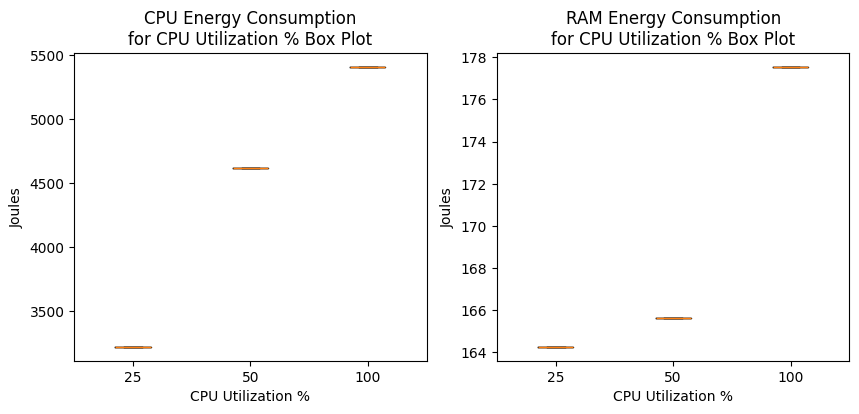

In [25]:
import matplotlib.pyplot as plt

# Format perf's label into a nicer string
PERF_CHART_TYPE_FORMAT = {
    "power/energy-pkg/": "CPU",
    "power/energy-ram/": "RAM",
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
axes = iter([ax1, ax2])

for chart_type, chart_data in data.items():
    subplot = next(axes)
    labels = list(chart_data.keys())
    values = list(chart_data.values())
    subplot.boxplot(values, labels=labels)
    
    subplot.set_title(f'{PERF_CHART_TYPE_FORMAT[chart_type]} Energy Consumption\nfor CPU Utilization % Box Plot')
    subplot.set_xlabel('CPU Utilization %')
    subplot.set_ylabel('Joules')
plt.show()